**USING COVID-19 DATA IN ORDER TO PREDICT PATIENT MORTALITY USING A LOGISTIC REGRESSION MODEL**

IMPORT PACKAGES & READ IN CSV

In [1]:
# import packages
import numpy as np
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.metrics import confusion_matrix, roc_curve, roc_auc_score, classification_report
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, cross_val_score, cross_val_predict, KFold
from sklearn.preprocessing import StandardScaler
from sklearn.base import TransformerMixin
from sklearn.pipeline import Pipeline

In [2]:
df = pd.read_csv("Covid Data.csv")
print(df.shape)
df.head()

(1048575, 21)


,USMER,MEDICAL_UNIT,SEX,PATIENT_TYPE,DATE_DIED,INTUBED,PNEUMONIA,AGE,PREGNANT,DIABETES,...,ASTHMA,INMSUPR,HIPERTENSION,OTHER_DISEASE,CARDIOVASCULAR,OBESITY,RENAL_CHRONIC,TOBACCO,CLASIFFICATION_FINAL,ICU
0,2,1,1,1,03/05/2020,97,1,65,2,2,...,2,2,1,2,2,2,2,2,3,97
1,2,1,2,1,03/06/2020,97,1,72,97,2,...,2,2,1,2,2,1,1,2,5,97
2,2,1,2,2,09/06/2020,1,2,55,97,1,...,2,2,2,2,2,2,2,2,3,2
3,2,1,1,1,12/06/2020,97,2,53,2,2,...,2,2,2,2,2,2,2,2,7,97
4,2,1,2,1,21/06/2020,97,2,68,97,1,...,2,2,1,2,2,2,2,2,3,97


FIRST LOOK

In [3]:
# data types look good. I do not plan on using the DATE_DIED column for analysis or
# model building so it's fine to leave as is
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1048575 entries, 0 to 1048574
Data columns (total 21 columns):
 #   Column                Non-Null Count    Dtype 
---  ------                --------------    ----- 
 0   USMER                 1048575 non-null  int64 
 1   MEDICAL_UNIT          1048575 non-null  int64 
 2   SEX                   1048575 non-null  int64 
 3   PATIENT_TYPE          1048575 non-null  int64 
 4   DATE_DIED             1048575 non-null  object
 5   INTUBED               1048575 non-null  int64 
 6   PNEUMONIA             1048575 non-null  int64 
 7   AGE                   1048575 non-null  int64 
 8   PREGNANT              1048575 non-null  int64 
 9   DIABETES              1048575 non-null  int64 
 10  COPD                  1048575 non-null  int64 
 11  ASTHMA                1048575 non-null  int64 
 12  INMSUPR               1048575 non-null  int64 
 13  HIPERTENSION          1048575 non-null  int64 
 14  OTHER_DISEASE         1048575 non-null  int64 
 15

In [4]:
# seems like there are no missing values besides the known 97, 98, 99 value placeholders (according to data card)
df.isnull().sum()

USMER                   0
MEDICAL_UNIT            0
SEX                     0
PATIENT_TYPE            0
DATE_DIED               0
INTUBED                 0
PNEUMONIA               0
AGE                     0
PREGNANT                0
DIABETES                0
COPD                    0
ASTHMA                  0
INMSUPR                 0
HIPERTENSION            0
OTHER_DISEASE           0
CARDIOVASCULAR          0
OBESITY                 0
RENAL_CHRONIC           0
TOBACCO                 0
CLASIFFICATION_FINAL    0
ICU                     0
dtype: int64

DATA CLEANING

In [5]:
# First thing to do is create our label. I wanted to use patient death as the variable to predict,
# but for that we would first have to create a new column using the DATE_DIED column in the dataset.

df['DEATH'] = [2 if row=='9999-99-99' else 1 for row in df['DATE_DIED']]
print(df['DEATH'].value_counts())

# Drop the DATE_DIED column since we no longer need it
df.drop('DATE_DIED', axis=1, inplace=True)

df.head()

DEATH
2    971633
1     76942
Name: count, dtype: int64


,USMER,MEDICAL_UNIT,SEX,PATIENT_TYPE,INTUBED,PNEUMONIA,AGE,PREGNANT,DIABETES,COPD,...,INMSUPR,HIPERTENSION,OTHER_DISEASE,CARDIOVASCULAR,OBESITY,RENAL_CHRONIC,TOBACCO,CLASIFFICATION_FINAL,ICU,DEATH
0,2,1,1,1,97,1,65,2,2,2,...,2,1,2,2,2,2,2,3,97,1
1,2,1,2,1,97,1,72,97,2,2,...,2,1,2,2,1,1,2,5,97,1
2,2,1,2,2,1,2,55,97,1,2,...,2,2,2,2,2,2,2,3,2,1
3,2,1,1,1,97,2,53,2,2,2,...,2,2,2,2,2,2,2,7,97,1
4,2,1,2,1,97,2,68,97,1,2,...,2,1,2,2,2,2,2,3,97,1


In [6]:
# Now it's time to deal with the missing values. First I want to see what the total counts
# of missing values are in each column

missing_vals = {}

for col in df.columns:
    missing_vals[col] = df.loc[(df[col] == 97) | (df[col] == 98) | (df[col] == 99), col].count()

print(missing_vals)

{'USMER': 0, 'MEDICAL_UNIT': 0, 'SEX': 0, 'PATIENT_TYPE': 0, 'INTUBED': 855869, 'PNEUMONIA': 16003, 'AGE': 345, 'PREGNANT': 527265, 'DIABETES': 3338, 'COPD': 3003, 'ASTHMA': 2979, 'INMSUPR': 3404, 'HIPERTENSION': 3104, 'OTHER_DISEASE': 5045, 'CARDIOVASCULAR': 3076, 'OBESITY': 3032, 'RENAL_CHRONIC': 3006, 'TOBACCO': 3220, 'CLASIFFICATION_FINAL': 0, 'ICU': 856032, 'DEATH': 0}


Based on the values in the dictionary:


Columns to drop: (too many missing values to keep)
* INTUBED
* ICU
* PREGNANT


Rows to drop: (few enough missing values that we can get away with dropping the full row)
* PNEUMONIA
* DIABETES
* COPD
* ASTHMA
* INMSUPR
* HIPERTENSION
* OTHER_DISEASE
* CARDIOVASCULAR
* OBESITY
* RENAL_CHRONIC
* TOBACCO


Note: No clue whether or not the 97,98,99 values for AGE are missing values or the
actual patient age, but it should be okay considering the size of the dataset

In [7]:
print(df.shape)

# drop cols
cols_to_drop = ['ICU', 'INTUBED', 'PREGNANT']
df.drop(cols_to_drop, axis=1, inplace=True)

# drop rows (wish there was a more condensed way to do this)
vals_to_drop = [97,98,99]
df = df[~df['PNEUMONIA'].isin(vals_to_drop)]
df = df[~df['DIABETES'].isin(vals_to_drop)]
df = df[~df['COPD'].isin(vals_to_drop)]
df = df[~df['ASTHMA'].isin(vals_to_drop)]
df = df[~df['INMSUPR'].isin(vals_to_drop)]
df = df[~df['HIPERTENSION'].isin(vals_to_drop)]
df = df[~df['OTHER_DISEASE'].isin(vals_to_drop)]
df = df[~df['CARDIOVASCULAR'].isin(vals_to_drop)]
df = df[~df['OBESITY'].isin(vals_to_drop)]
df = df[~df['RENAL_CHRONIC'].isin(vals_to_drop)]
df = df[~df['TOBACCO'].isin(vals_to_drop)]

print(df.shape)

(1048575, 21)
(1025152, 18)


In [8]:
# seems like we got rid of all of our missing values
for col in df.columns:
    print(col)
    print(df[col].unique())

USMER
[2 1]
MEDICAL_UNIT
[ 1  2  3  4  5  6  7  8  9 10 11 12 13]
SEX
[1 2]
PATIENT_TYPE
[1 2]
PNEUMONIA
[1 2]
AGE
[ 65  72  55  53  68  40  64  37  25  38  24  30  48  23  80  61  54  59
  45  26  32  49  39  27  57  20  56  47  50  46  43  28  33  16  62  58
  36  44  66  52  51  35  19  90  34  22  29  14  31  42  15   0  17  41
   2  10   1  12   4   7   6   8  60   5  13  63  75  81  67  18  70  88
  85  92  73  74  78  76  82  77  86  71  95  87  83  84  79  69  89   3
  97  93 100  91  21 103  11   9  94  96 101 107 102  98  99 109 116 105
 111 104 114 120 106 110 118 117 121 108 115 119 113]
DIABETES
[2 1]
COPD
[2 1]
ASTHMA
[2 1]
INMSUPR
[2 1]
HIPERTENSION
[1 2]
OTHER_DISEASE
[2 1]
CARDIOVASCULAR
[2 1]
OBESITY
[2 1]
RENAL_CHRONIC
[2 1]
TOBACCO
[2 1]
CLASIFFICATION_FINAL
[3 5 7 6 1 2 4]
DEATH
[1 2]


EDA

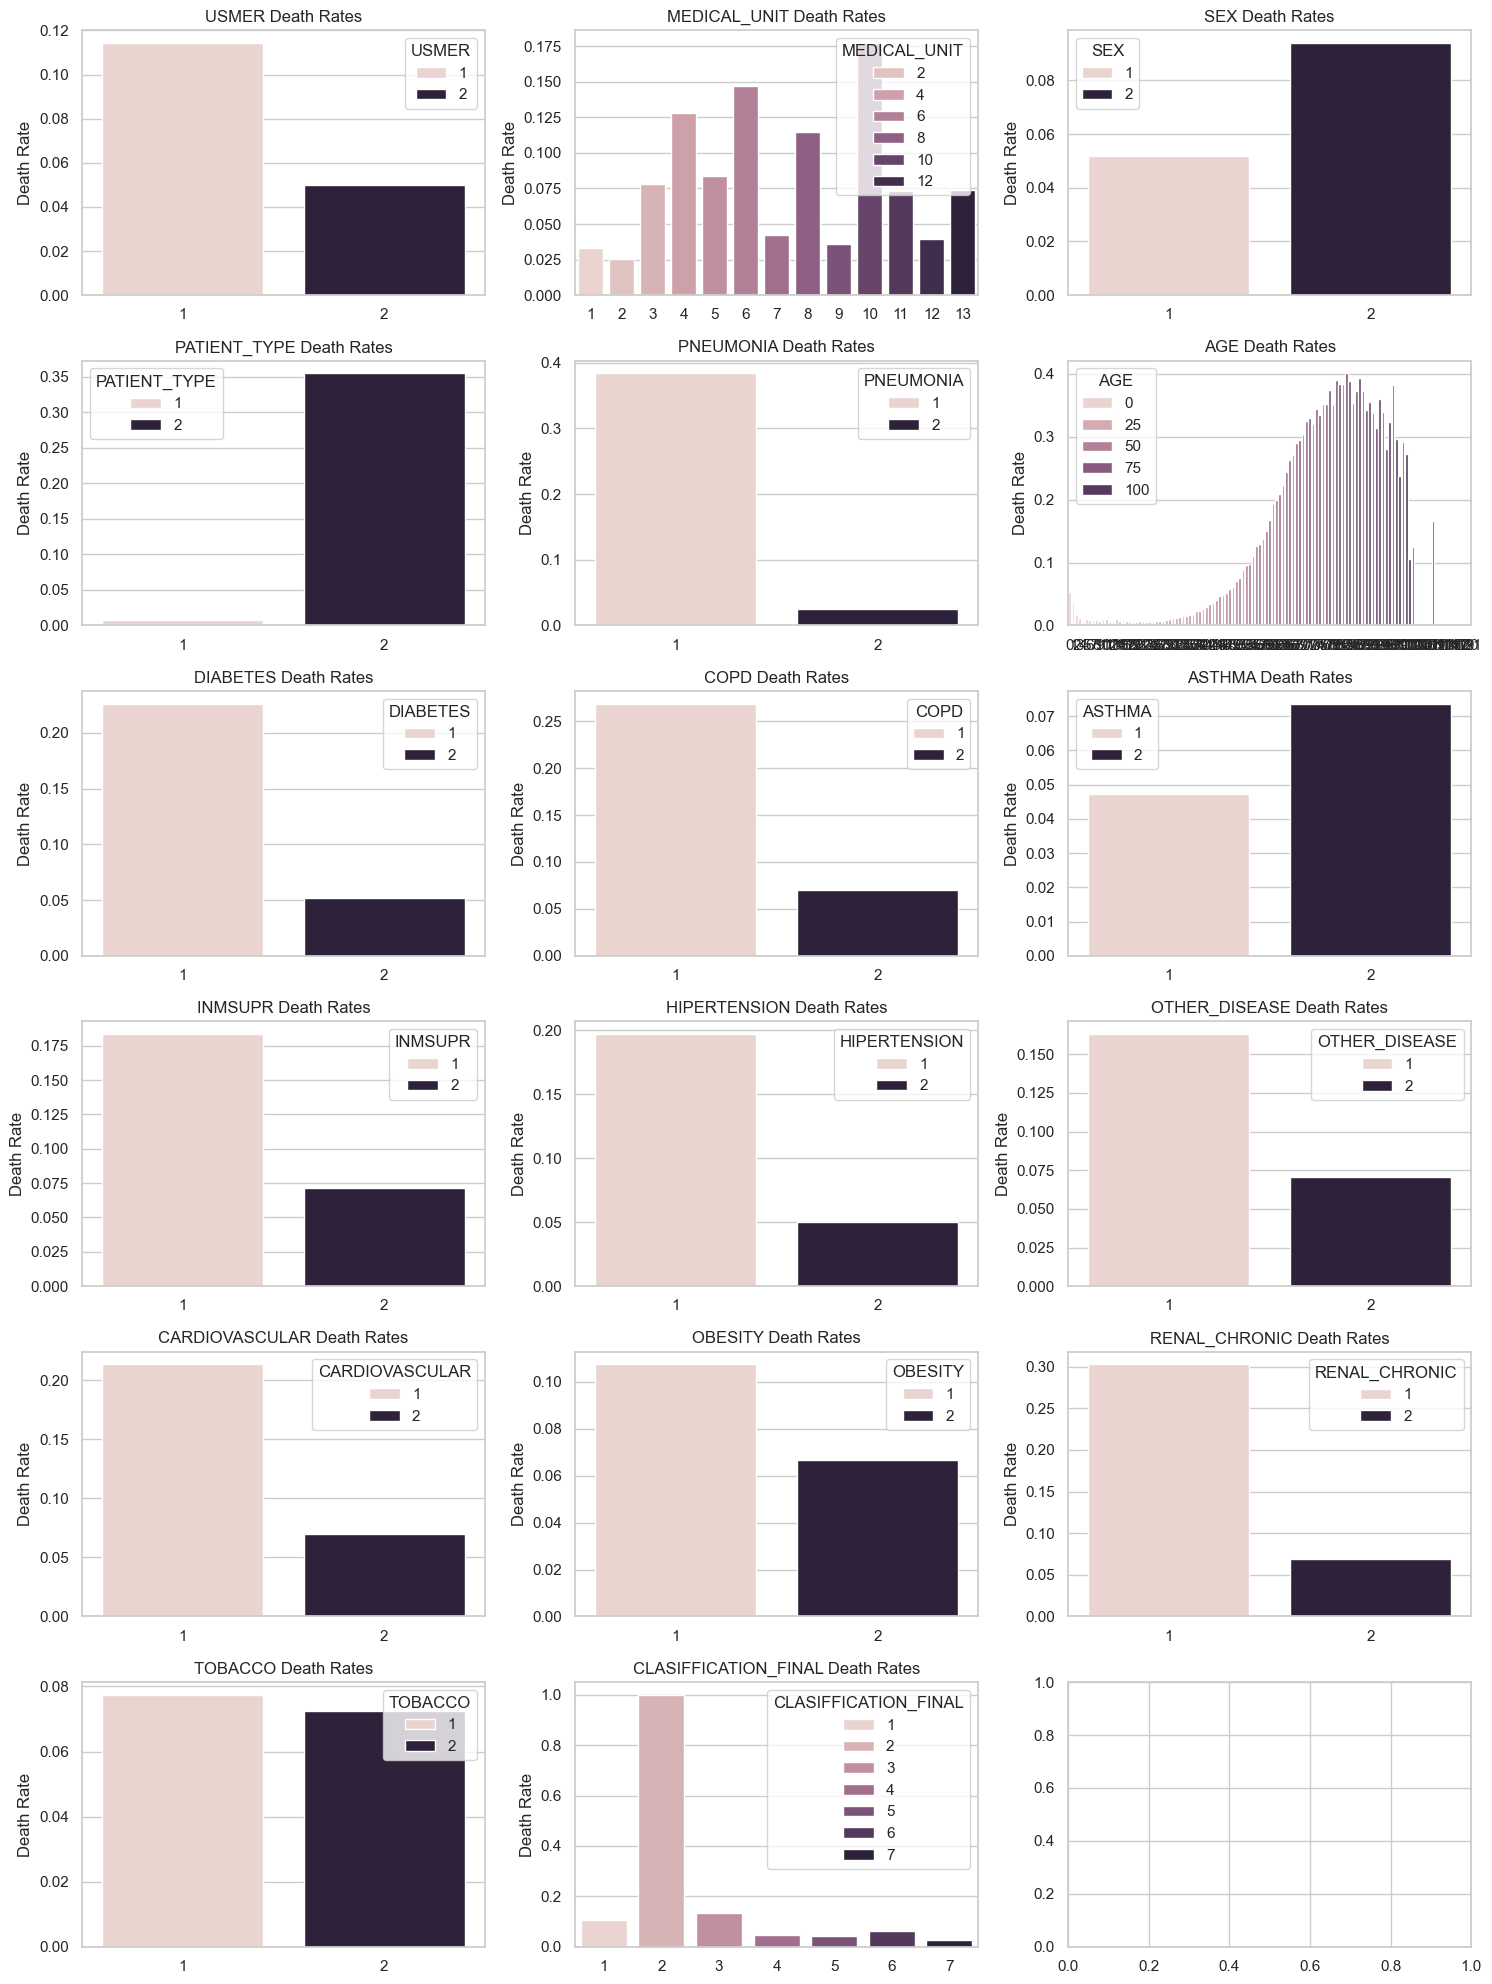

In [21]:
# it's important to visualize some of our potential features before we use them in our model to see how they affect our label.
# here, I'm mainly curious to see if certain values are associated with a higher death rate for a patient.

sns.set(style="whitegrid")

# feature names that I want to analyze
features_to_analyze = ['USMER', 'MEDICAL_UNIT', 'SEX', 'PATIENT_TYPE', 'PNEUMONIA', 'AGE',
                        'DIABETES', 'COPD', 'ASTHMA', 'INMSUPR', 'HIPERTENSION', 'OTHER_DISEASE',
                        'CARDIOVASCULAR', 'OBESITY', 'RENAL_CHRONIC', 'TOBACCO', 'CLASIFFICATION_FINAL']

# set up subplots
num_rows = 6
num_cols = 3
fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, 20))

# plot features against DEATH with death rates
for i, feature in enumerate(features_to_analyze):
    row = i // num_cols
    col = i % num_cols
    
    # calculate death rates
    death_rates = df.groupby([feature, 'DEATH']).size().unstack(fill_value=0)
    death_rates['Death Rate'] = death_rates[1] / (death_rates[1] + death_rates[2])
    
    # plot the death rates
    sns.barplot(x=death_rates.index, y='Death Rate', data=death_rates.reset_index(), hue=feature, ax=axes[row, col])
    
    axes[row, col].set_title(f'{feature} Death Rates')
    axes[row, col].set_ylabel('Death Rate')
    axes[row, col].set_xlabel('')
    axes[row, col].legend(title=feature)

# adjust layout
plt.tight_layout()
plt.show()

It seems a large amount of these features are quite predictive of death in a patient. Tobacco is the one columm I can see that may not be the most useful to keep as a feature

LOGISTIC REGRESSION (Binary Classification)

In [9]:
# reminder of what the dataset looks like
df.head()

,USMER,MEDICAL_UNIT,SEX,PATIENT_TYPE,PNEUMONIA,AGE,DIABETES,COPD,ASTHMA,INMSUPR,HIPERTENSION,OTHER_DISEASE,CARDIOVASCULAR,OBESITY,RENAL_CHRONIC,TOBACCO,CLASIFFICATION_FINAL,DEATH
0,2,1,1,1,1,65,2,2,2,2,1,2,2,2,2,2,3,1
1,2,1,2,1,1,72,2,2,2,2,1,2,2,1,1,2,5,1
2,2,1,2,2,2,55,1,2,2,2,2,2,2,2,2,2,3,1
3,2,1,1,1,2,53,2,2,2,2,2,2,2,2,2,2,7,1
4,2,1,2,1,2,68,1,2,2,2,1,2,2,2,2,2,3,1


In [23]:
# choose features. I will simply comment out all lines besides the one I want to use for
# the model and see how that affects the model's performance in the later code.
# it makes it a bit harder to compare, but also makes the code a thousand times more
# readable for me personally.

#X = df.drop(['DEATH'], axis=1) # using all features to see what we are working with
X = df.drop(['DEATH','TOBACCO'], axis=1) # dropping tobacco to see whether something changes, since it has the lowest ratio for death vs no death in the EDA

y = df['DEATH']

In [24]:
# set up a pipeline to scale the data and apply logistic regression model

# we are using a logistic regression model since we are trying to perform 
# binary classification with primarily binary columns

steps = [('scaler', StandardScaler()),
          ('logreg', LogisticRegression(max_iter=200, solver='liblinear'))]


pipeline = Pipeline(steps)

# set up KFold for cross-validation
kf = KFold(n_splits=5, shuffle=True, random_state=42)

cv_results = cross_val_score(pipeline, X, y, cv=kf)

print("Cross-Validation Results:")
print(cv_results)

Cross-Validation Results:
[0.93831177 0.93720462 0.93796518 0.93659952 0.93819929]


In [25]:
# data has a 92%/8% split, 93.8% accuracy is better than random guessing (when using all features)

df["DEATH"].value_counts(normalize=True)

DEATH
2    0.927119
1    0.072881
Name: proportion, dtype: float64

CONFUSION MATRIX

In [26]:
# cross validated predictions
y_pred = cross_val_predict(pipeline, X, y, cv=kf)

# print the confusion matrix to see where the issues with accuracy are coming from
# since we are dealing with a very unbalanced dataset and accuracy is not a good 
# enough metric by itself to evaluate model performance.

# accuracy is generally a better tool to evaluate model performance on balanced data

print("\nConfusion Matrix:")
print(confusion_matrix(y, y_pred))


Confusion Matrix:
[[ 32846  41868]
 [ 22044 928394]]


In [27]:
# print the classification report

print("\nClassification Report:")
print(classification_report(y, y_pred))


Classification Report:
              precision    recall  f1-score   support

           1       0.60      0.44      0.51     74714
           2       0.96      0.98      0.97    950438

    accuracy                           0.94   1025152
   macro avg       0.78      0.71      0.74   1025152
weighted avg       0.93      0.94      0.93   1025152



ROC CURVE

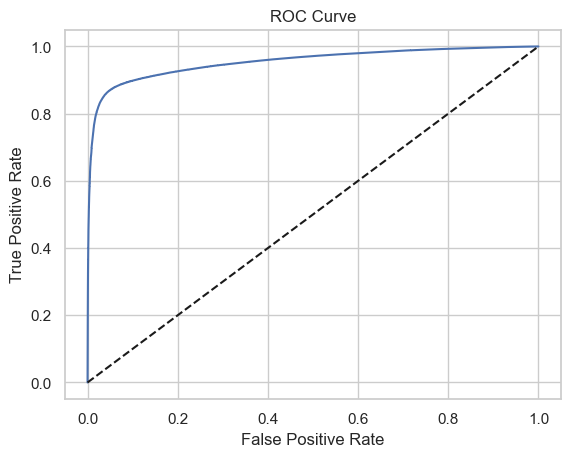

AUC-ROC: 0.9541538684692024


In [28]:
y_prob = cross_val_predict(pipeline, X, y, cv=kf, method='predict_proba')

fpr, tpr, thresholds = roc_curve(y, y_prob[:, 1], pos_label=2)

# plot the ROC curve
plt.plot(fpr, tpr, label='ROC curve')
plt.plot([0,1],[0,1],'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.show()

# calculate AUC-ROC
auc_roc = roc_auc_score(y, y_prob[:, 1])
print(f'AUC-ROC: {auc_roc}')

# seems like the model performs better than random guessing due to the high area under the ROC curve.

PRECISION-RECALL CURVE

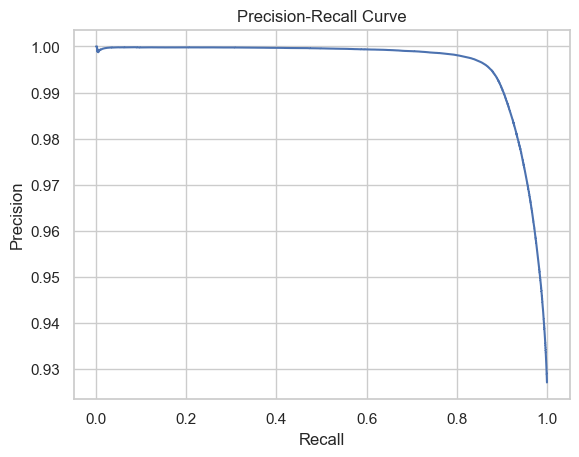

AUC-PR: 0.9961776815544177
Best Threshold (Precision-Recall): 0.43769284539248515


In [29]:
from sklearn.metrics import precision_recall_curve, auc

precision, recall, thresholds_pr = precision_recall_curve(y, y_prob[:, 1], pos_label=2)

# plot precision recall curve
plt.plot(recall, precision, label='Precision-Recall curve')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.show()

# Calculate AUC-PR
auc_pr = auc(recall, precision)
print(f'AUC-PR: {auc_pr}')

# find the threshold that maximizes the F1 score
best_threshold_pr = thresholds_pr[np.argmax(2 * precision * recall / (precision + recall))]
print(f'Best Threshold (Precision-Recall): {best_threshold_pr}')


Main Takeaways?

* It seems like removing the tobacco column did not significantly impact the model's performance neither positively nor negatively. If I was dealing with a larger dataset or a different model where training time was more of an issue, I'd keep this in mind.
* The code doesn't take very long at all to run even when we keep all features, so it is safe to say keeping all features is worth it in this case.
* It seems like the best option going forward to increase model accuracy/precision/recall would be to choose a different type of model or try some more advanced machine learning libraries/models.
* While I didn't show it here, I also played around with some hyperparameters and didn't get any meaningful results from using l2 regularization, different solvers, or even using a different scaler.